# Motive

In our current pipeline, we use the label function from Scipy's measurements library in the Connected Components step because of its speed and accuracy. In the next step, we search through the entire array for indices that contain each label, and then put same-labeled indices in a memberlist which then gets passed into a Cluster class. This member-find step is extremely time inefficient. Thus, I would like to find a way to speed up this process.

# The Data
I will be using a 1024x1024x5 subvolume of tp1. The pixel intensity distribution is approximately the same as that of the total image volume (i.e., 98% background, 2% synapse). 

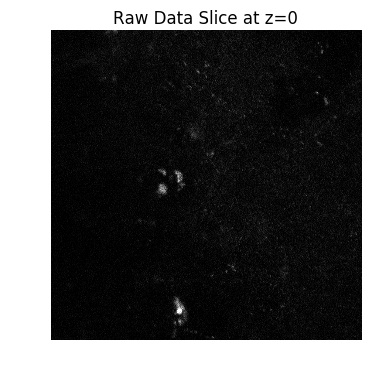

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../code/functions/')
import tiffIO as tIO
import connectLib as cLib
import plosLib as pLib
import time

dataSubset = tIO.unzipChannels(tIO.loadTiff('../data/SEP-GluA1-KI_tp1.tif'))[0][0:5]
plt.imshow(dataSubset[0], cmap="gray")
plt.axis('off')
plt.title('Raw Data Slice at z=0')
plt.show()

In [55]:
#finding the clusters after plosPipeline
plosOutSub = pLib.pipeline(dataSubset)

In [56]:
#binarize output of plos lib
bianOutSub = cLib.otsuVox(plosOutSub)

In [57]:
#dilate the output based on neigborhood size
bianOutSub = ndimage.morphology.binary_dilation(bianOutSub).astype(int)

Time Taken to Run Connected Components: 0.0643181800842s


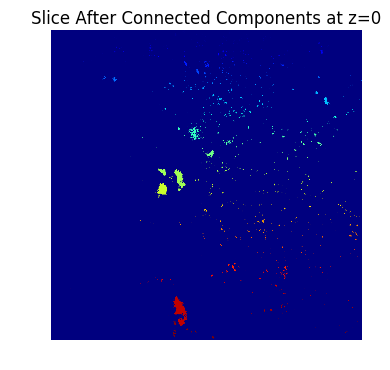

In [216]:
s = [[[1 for k in xrange(3)] for j in xrange(3)] for i in xrange(3)]
start_time = time.time()

# find connected components
label_im, nr_objects = ndimage.label(bianOutSub, s) 
CC_time = time.time() - start_time
print 'Time Taken to Run Connected Components: ' + str(CC_time) + 's'

#displaying a slice
plt.imshow(labeled_im[0])
plt.title('Slice After Connected Components at z=0')
plt.axis('off')
plt.show()

# Approach 1: Volume Thresholding Before Cluster Class
The labeled cluster will be thresholded such that we get rid of each cluster above 138 volume before we perform memberfind.

Time Taken to Volume Threshold: 0.153381109238s


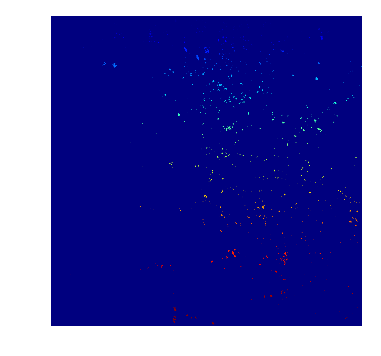

In [215]:
start_time = time.time()
mask = dataSubset > dataSubset.mean()
sizes = ndimage.sum(mask, label_im, range(nr_objects + 1))
mask_size = sizes > 1000
remove_pixel = mask_size[label_im]
label_im[remove_pixel] = 0
Threshold_time = time.time() - start_time
print 'Time Taken to Volume Threshold: ' + str(Threshold_time) + 's'
plt.imshow(label_im[0])   
plt.axis('off')
plt.show()

In [217]:
start_time = time.time()
temp, temp_nr_objects = ndimage.label(label_im, s) 
sizesTemp = ndimage.sum(mask, temp, range(temp_nr_objects + 1))
sizesTempRemoved0 = [sizesTemp[i] for i in range(1, len(sizesTemp))]
Volume_find_time = time.time() - start_time
print 'Time Taken to Find Volumes: ' + str(Volume_find_time) + 's'

Time Taken to Find Volumes: 0.170244932175s


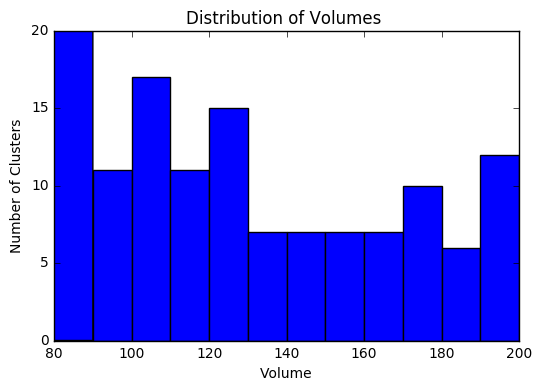

In [212]:
import pylab

pylab.hist(sizesTempRemoved0, bins=[10*i for i in range(8, 21)])
pylab.xlabel('Volume')
pylab.title('Distribution of Volumes ')
pylab.ylabel('Number of Clusters')
pylab.show()

In [218]:
start_time = time.time()
centers = ndimage.measurements.center_of_mass(dataSubset, temp, [i for i in range(temp_nr_objects)])
Centroid_find_time = time.time() - start_time
print 'Time Taken to Find Centroids: ' + str(Centroid_find_time) + 's'

Time Taken to Find Centroids: 0.406000137329s


In [223]:
total_time = CC_time + Threshold_time + Volume_find_time + Centroid_find_time
print "Total Time taken for Connected Components + Volume Thresholding + Finding Centroids \n+ Finding List of Volumes = " + str(total_time) + "s"

Total Time taken for Connected Components + Volume Thresholding + Finding Centroids 
+ Finding List of Volumes = 0.793944358826s
